In [33]:
# %%
import random
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np # Needed for bearing calculation if not present

print("OSMnx version:", ox.__version__)  # sanity check
# Ensure you have a recent version, e.g., >= 1.1.0

OSMnx version: 2.0.2


In [34]:
# %%
# Download the drivable street network for San Francisco
# Using a smaller area for faster processing during testing might be helpful
# For example: G = ox.graph_from_point((37.7749, -122.4194), dist=1500, network_type="drive")
G = ox.graph_from_place(
    "San Francisco, California, USA",
    network_type="drive",
)
print("Graph downloaded.")

Graph downloaded.


In [35]:
# %%
# Ensure graph is undirected using the function for OSMnx v2.x
print("Converting graph to undirected...")
G_undirected = ox.convert.to_undirected(G)

# Calculate edge bearings using the function for OSMnx v2.x
# This adds/updates the 'bearing' attribute to each edge.
print("Adding edge bearings...")
G_undirected = ox.bearing.add_edge_bearings(G_undirected) # Use ox.bearing submodule

print(f"Graph has {G_undirected.number_of_nodes()} nodes and {G_undirected.number_of_edges()} edges.")
print("Converted graph to undirected and added edge bearings.")

# Optional: Verify bearing attribute exists
try:
    if G_undirected.number_of_edges() > 0:
        first_edge_data = next(iter(G_undirected.edges(data=True))) # Get u, v, data tuple
        if 'bearing' in first_edge_data[2]: # Check data dict
            print("Verified 'bearing' attribute exists in edge data.")
        else:
            print("Warning: 'bearing' attribute still seems missing after add_edge_bearings.")
except StopIteration:
    print("Graph has no edges to check.")

Converting graph to undirected...
Adding edge bearings...
Graph has 10006 nodes and 16533 edges.
Converted graph to undirected and added edge bearings.
Verified 'bearing' attribute exists in edge data.


In [36]:
# %%
# Assign a random NS/EW phase to each intersection (node)
node_phase = {node: random.choice(['NS', 'EW']) for node in G_undirected.nodes()}
print(f"Assigned random NS/EW phases to {len(node_phase)} nodes.")

# Iterate through edges to determine signal group and green status at each end
default_signal_group = 'NS' # Assign a default if bearing calc fails
edges_processed = 0
missing_bearings = 0
for u, v, data in G_undirected.edges(data=True):
    edges_processed += 1
    # Ensure bearing is present and valid before calculating signal group
    if 'bearing' not in data or data['bearing'] is None:
        print(f"Warning: Bearing missing or None for edge ({u}, {v}). Attempting recalculation.")
        missing_bearings += 1
        # Check if nodes have geometry data
        try:
            y1, x1 = G_undirected.nodes[u]['y'], G_undirected.nodes[u]['x']
            y2, x2 = G_undirected.nodes[v]['y'], G_undirected.nodes[v]['x']
            # Use the bearing calculation function
            data['bearing'] = ox.bearing.calculate_bearing(y1, x1, y2, x2)
            print(f"Recalculated bearing for edge ({u}, {v}): {data['bearing']:.2f}")
        except KeyError:
            print(f"Error: Node geometry ('y' or 'x') missing for nodes {u} or {v}. Cannot calculate bearing.")
            data['bearing'] = None # Mark bearing as invalid

    # Proceed if bearing is valid
    if data.get('bearing') is not None: # Use .get() for safety
        b = data['bearing']
        # Determine the signal group ('NS' or 'EW') based on bearing
        is_ew_bearing = (45 <= b < 135) or (225 <= b < 315)
        data['signal_group'] = 'EW' if is_ew_bearing else 'NS'
    else:
        print(f"Assigning default signal group '{default_signal_group}' to edge ({u}, {v}) due to missing bearing.")
        data['signal_group'] = default_signal_group

    # Determine if the light is green from the perspective of node u and v
    # Check node_phase existence for safety, though it should exist for all nodes
    data['is_green_u'] = (data['signal_group'] == node_phase.get(u))
    data['is_green_v'] = (data['signal_group'] == node_phase.get(v))

print(f"Found {missing_bearings} edges with missing bearings out of {edges_processed} total edges.")
print(f"Finished assigning edge signal groups and green states for {edges_processed} edges.")

Assigned random NS/EW phases to 10006 nodes.
Recalculated bearing for edge (65280069, 65280069): 0.00
Recalculated bearing for edge (65287649, 65287649): 0.00
Recalculated bearing for edge (65289331, 65289331): 0.00
Recalculated bearing for edge (65310602, 65310602): 0.00
Recalculated bearing for edge (65311975, 65311975): 0.00
Recalculated bearing for edge (65314304, 65314304): 0.00
Recalculated bearing for edge (65318497, 65318497): 0.00
Recalculated bearing for edge (65325125, 65325125): 0.00
Recalculated bearing for edge (65333713, 65333713): 0.00
Recalculated bearing for edge (65337088, 65337088): 0.00
Recalculated bearing for edge (65349151, 65349151): 0.00
Recalculated bearing for edge (65359648, 65359648): 0.00
Recalculated bearing for edge (257316381, 257316381): 0.00
Recalculated bearing for edge (263133817, 263133817): 0.00
Recalculated bearing for edge (316735471, 316735471): 0.00
Recalculated bearing for edge (554160413, 554160413): 0.00
Recalculated bearing for edge (8308

In [37]:
# %%
# Create a list of colors for plotting based on the states at *both* ends
edge_colors = []
color_counts = {'lime': 0, 'red': 0, 'orange': 0, 'gray': 0} # Track colors assigned

for u, v, data in G_undirected.edges(data=True):
    # Use .get() for safety in case attributes weren't assigned
    green_u = data.get('is_green_u', False)
    green_v = data.get('is_green_v', False)

    if green_u and green_v:
        color = 'lime' # Both ends green
    elif not green_u and not green_v:
        color = 'red'  # Both ends red
    elif green_u or green_v: # Check if at least one is green
        color = 'orange' # One end green, one end red (transition)
    else:
        # This case should ideally not happen if is_green_u/v are always boolean
        # Could occur if node_phase.get() returned None and comparison failed
        print(f"Warning: Unexpected state for edge ({u},{v}). Assigning gray.")
        color = 'gray'

    edge_colors.append(color)
    color_counts[color] += 1

print(f"Generated {len(edge_colors)} edge colors for simplified plotting.")
print(f"Color distribution: {color_counts}")

Generated 16533 edge colors for simplified plotting.
Color distribution: {'lime': 4115, 'red': 4112, 'orange': 8306, 'gray': 0}


Plotting graph...


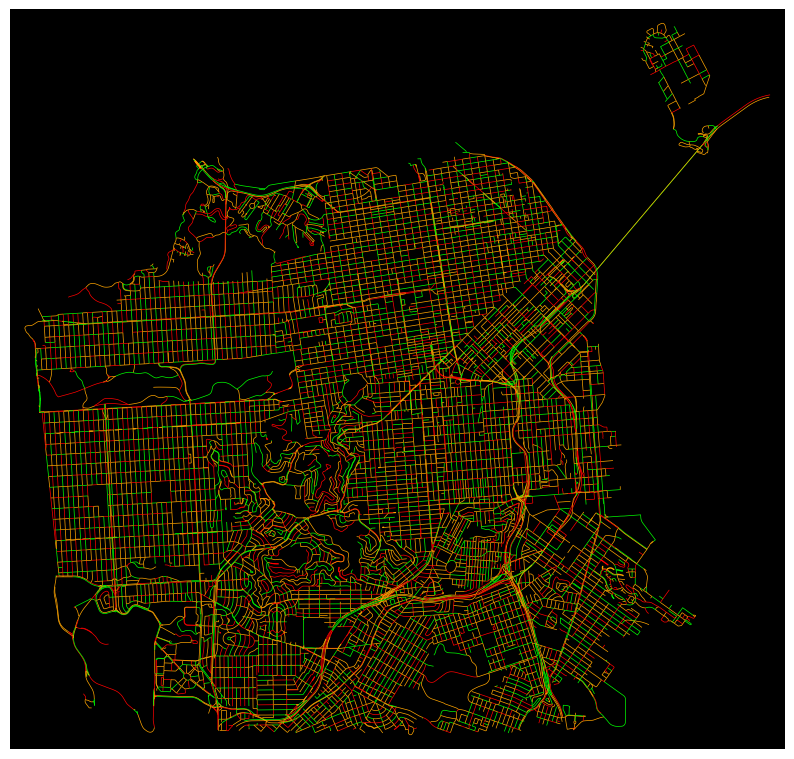

Plot displayed.


In [38]:
# %%
# Plot the graph with edges colored by combined traffic light status
print("Plotting graph...")
fig, ax = ox.plot_graph(
    G_undirected,
    node_size=0,        # Hide nodes for clarity
    edge_color=edge_colors,
    edge_linewidth=0.5, # Thin edges
    figsize=(10, 10),   # Adjust figure size as needed
    bgcolor='black'     # Use a black background
)
plt.show() # Display the plot
print("Plot displayed.")

In [39]:
# %%
# Convert graph edges to GeoDataFrame
print("Converting graph edges to GeoDataFrame...")
# With OSMnx v2.x, graph_to_gdfs automatically includes attributes by default
# Specify edges=True, nodes=False explicitly for clarity
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_undirected, nodes=True, edges=True) # Get both for easy node attr access if needed

# Reset index to turn MultiIndex (u, v, key) into columns
gdf_edges = gdf_edges.reset_index()
print("GeoDataFrame created.")
print(f"Initial Edge GeoDataFrame columns: {gdf_edges.columns.tolist()}")

Converting graph edges to GeoDataFrame...
GeoDataFrame created.
Initial Edge GeoDataFrame columns: ['u', 'v', 'key', 'osmid', 'highway', 'lanes', 'maxspeed', 'name', 'oneway', 'ref', 'reversed', 'length', 'bridge', 'tunnel', 'geometry', 'from', 'to', 'bearing', 'signal_group', 'is_green_u', 'is_green_v', 'width', 'access', 'junction']


In [ ]:
# %%
# Create a new column 'viz_color' in the GeoDataFrame for Kepler visualization
print("Creating 'viz_color' column for Kepler.gl...")
color_mapping_list = []
for index, row in gdf_edges.iterrows():
    green_u = row.get('is_green_u', False) # Use .get() for safety
    green_v = row.get('is_green_v', False)

    if green_u and green_v:
        color = 'lime'
    elif not green_u and not green_v:
        color = 'red'
    elif green_u or green_v:
        color = 'orange'
    else:
        # Fallback for any unexpected cases
        color = 'gray'
    color_mapping_list.append(color)

gdf_edges['viz_color'] = color_mapping_list
print("Added 'viz_color' column to GeoDataFrame.")
print(f"Value counts for 'viz_color':\n{gdf_edges['viz_color'].value_counts()}")

In [43]:
# %%
# Select and keep relevant columns for export, INCLUDING 'viz_color'
export_columns = ['u', 'v', 'osmid', 'geometry', 'signal_group',
                  'is_green_u', 'is_green_v', 'bearing', 'length',
                  'viz_color'] # <-- Added 'viz_color' here

# Filter GeoDataFrame to only include desired columns
# Check which of the desired columns actually exist in the GDF
final_export_columns = [col for col in export_columns if col in gdf_edges.columns]
print(f"Columns selected for export: {final_export_columns}")

# Create the final GDF for export, using .copy()
edges_export_gdf = gdf_edges[final_export_columns].copy()

# Handle potential list-type 'osmid'
if 'osmid' in edges_export_gdf.columns:
    is_list_mask = edges_export_gdf['osmid'].apply(isinstance, args=(list,))
    if is_list_mask.any():
        print("Handling list-type OSMIDs by taking the first element...")
        edges_export_gdf.loc[is_list_mask, 'osmid'] = edges_export_gdf.loc[is_list_mask, 'osmid'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

print("Selected and prepared columns for export.")

Columns selected for export: ['u', 'v', 'osmid', 'geometry', 'signal_group', 'is_green_u', 'is_green_v', 'bearing', 'length', 'viz_color']
Handling list-type OSMIDs by taking the first element...
Selected and prepared columns for export.


In [44]:
# %%
# Export the detailed edges GeoDataFrame to GeoJSON
output_filename = "edges_with_traffic_states_v2.geojson"
print(f"Exporting GeoDataFrame to {output_filename}...")
edges_export_gdf.to_file(output_filename, driver="GeoJSON")

print(f"Exported edge data with traffic states to {output_filename}")
print(f"Final GeoDataFrame has columns: {edges_export_gdf.columns.tolist()}")
# Display first few rows to verify
print("First 5 rows of exported data:")
print(edges_export_gdf.head())

Exporting GeoDataFrame to edges_with_traffic_states_v2.geojson...
Exported edge data with traffic states to edges_with_traffic_states_v2.geojson
Final GeoDataFrame has columns: ['u', 'v', 'osmid', 'geometry', 'signal_group', 'is_green_u', 'is_green_v', 'bearing', 'length', 'viz_color']
First 5 rows of exported data:
          u           v      osmid  \
0  32927563  4377020523  661905446   
1  32927563   915248218  661905443   
2  32927563  3910307153  661905445   
3  32927591   315706881   28715659   
4  32927591  6469349533  689603997   

                                            geometry signal_group  is_green_u  \
0  LINESTRING (-122.3909 37.78602, -122.39069 37....           NS        True   
1  LINESTRING (-122.39158 37.78558, -122.39146 37...           EW       False   
2  LINESTRING (-122.39281 37.78372, -122.39291 37...           NS        True   
3  LINESTRING (-122.42367 37.73137, -122.42318 37...           EW       False   
4  LINESTRING (-122.42367 37.73137, -122.42357 3